In [2]:
import matplotlib.pyplot as plt
import numpy as np
from metamod.utils import QAnalysis
from sklearn.decomposition import PCA, KernelPCA, FastICA
from sklearn.manifold import Isomap
import matplotlib.cm as cm

Loading BokehJS ...

In [3]:
verbose = True
results_path = "../results/task_switch_main/slow_switch_run0_AffineCorrelatedGaussian_27-12-2022_20-36-08-225"
q_iters = 2000

In [4]:
qa = QAnalysis(results_path=results_path, verbose=verbose, q_iters=q_iters)

### Results from ../results/task_switch_main/slow_switch_run0_AffineCorrelatedGaussian_27-12-2022_20-36-08-225 ###
### Param Keys ###
--- dataset_params ---
dataset1_params, dataset2_params, dataset_classes, change_tasks_every, dataset
--- model_params ---
learning_rate, hidden_dim, intrinsic_noise, reg_coef, W1_0, W2_0, input_dim, output_dim, model
--- equation_params ---
in_cov, out_cov, in_out_cov, init_weights, n_steps, reg_coef, intrinsic_noise, learning_rate, change_task_every, time_constant, solver
--- control_params ---
control_lower_bound, control_upper_bound, gamma, cost_coef, reward_convertion, init_g, control_lr, in_cov, out_cov, in_out_cov, init_weights, n_steps, reg_coef, intrinsic_noise, learning_rate, change_task_every, time_constant, iters_control, control
--- reset_model_params ---
learning_rate, hidden_dim, intrinsic_noise, reg_coef, W1_0, W2_0, input_dim, output_dim, model
### Results Keys ###
dict_keys(['iters', 'Loss_t_sim', 'weights_sim', 'weights_iters_sim', 'ti

# Loss landscape 

In [98]:
baseline_W = qa.baseline_W2 @ qa.baseline_W1
control_W = qa.control_W2 @ qa.control_W1
tilde_W = qa.W2_tilde @ qa.W1_tilde

In [99]:
baseline_W.shape

(23000, 2, 3)

In [100]:
flatten_b_W = np.reshape(baseline_W, newshape=(baseline_W.shape[0], -1))
flatten_c_W = np.reshape(control_W, newshape=(control_W.shape[0], -1))
flatten_t_W = np.reshape(tilde_W, newshape=(tilde_W.shape[0], -1))

In [101]:
all_W = np.concatenate([flatten_b_W, flatten_c_W, flatten_t_W])

In [125]:
pca_W = PCA(n_components=2).fit(all_W)
pca_W.components_

array([[-9.5178276e-01,  2.9759899e-01,  7.8032311e-04,  6.9572940e-02,
         2.6520774e-02, -3.7691530e-04],
       [-2.5117409e-01, -7.1587229e-01, -2.4940108e-03, -1.3066842e-01,
        -6.3824296e-01,  1.9929258e-03]], dtype=float32)

In [103]:
proj_b = pca_W.transform(flatten_b_W)
proj_c = pca_W.transform(flatten_c_W)
proj_t = pca_W.transform(flatten_t_W)
proj_sol1 = pca_W.transform(qa.task1_solution.flatten()[np.newaxis, :])
proj_sol2 = pca_W.transform(qa.task2_solution.flatten()[np.newaxis, :])

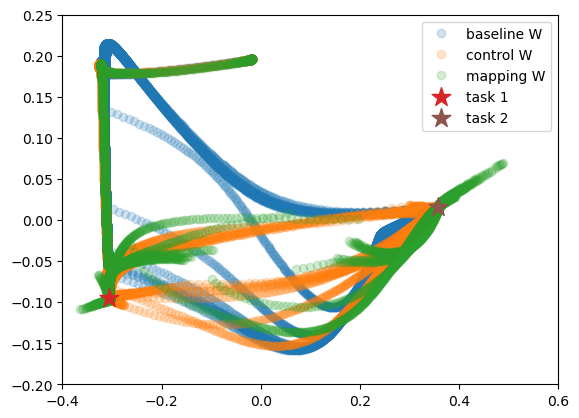

In [104]:
alpha = 0.2
plt.plot(proj_b[:, 0], proj_b[:, 1], "o", label="baseline W", alpha=alpha)
plt.plot(proj_c[:, 0], proj_c[:, 1], "o", label="control W", alpha=alpha)
plt.plot(proj_t[:, 0], proj_t[:, 1], "o", label="mapping W", alpha=alpha)
plt.scatter(proj_sol1[:, 0], proj_sol1[:, 1], s=200, c="C3", marker="*", label="task 1", zorder=2)
plt.scatter(proj_sol2[:, 0], proj_sol2[:, 1], s=200, c="C5", marker="*", label="task 2", zorder=2)
plt.xlim([-0.4, 0.6])
plt.ylim([-0.2, 0.25])
plt.legend()
plt.show()

In [174]:
n_dots = 50000
#weight_sampling = np.random.normal(scale=0.1, size=(n_dots, qa.baseline_fp.shape[1]*qa.baseline_fp.shape[2])) + qa.task1_solution.flatten()
weight_sampling = np.random.normal(scale=np.abs(np.sum(pca_W.components_, axis=0))*0.5, size=(n_dots, qa.baseline_fp.shape[1]*qa.baseline_fp.shape[2]))#+ qa.task1_solution.flatten()
random_points = pca_W.transform(weight_sampling)

distance_task1 = 1/(np.sqrt(np.sum((qa.task1_solution.flatten()-weight_sampling)**2, axis=-1))+1e-4)
distance_task2 = 1/np.sqrt(np.sum((qa.task2_solution.flatten()-weight_sampling)**2, axis=-1)+1e-4)

In [175]:
n_dist1 = (distance_task1 - np.min(distance_task1))/np.amax(distance_task1 - np.min(distance_task1))
colors1 = cm.viridis(n_dist1)
n_dist2 = (distance_task2 - np.min(distance_task2))/np.amax(distance_task2 - np.min(distance_task2))
colors2 = cm.viridis(n_dist2)

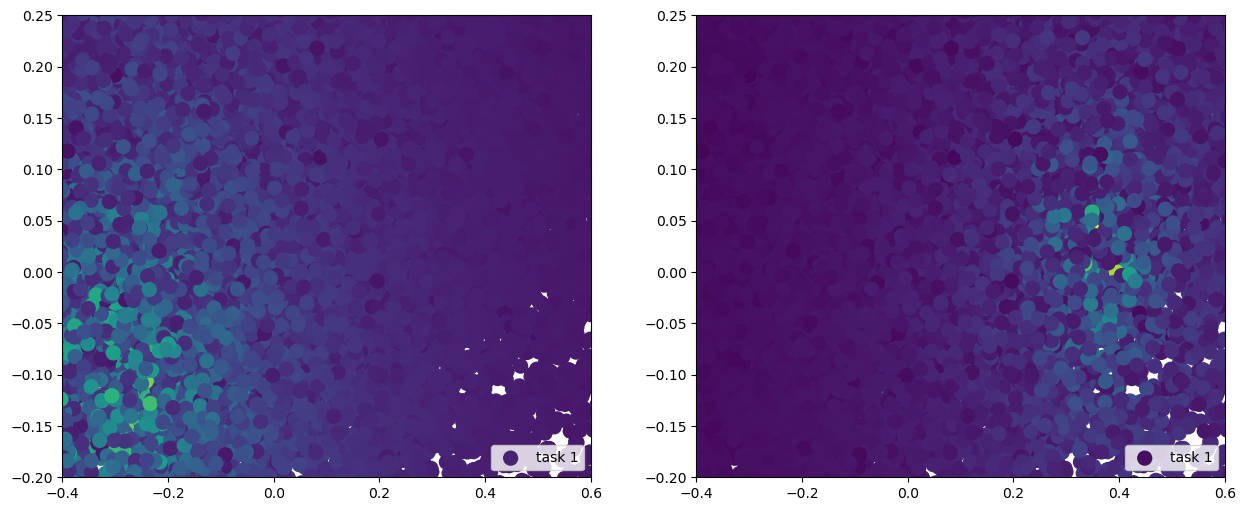

In [176]:
f, ax = plt.subplots(1, 2, figsize=(15, 6))


ax[0].scatter(random_points[:, 0], random_points[:, 1], s=100, c=colors1, cmap=cm.viridis, marker="o", label="task 1", zorder=2)
ax[0].set_xlim([-0.4, 0.6])
ax[0].set_ylim([-0.2, 0.25])
ax[0].legend()

ax[1].scatter(random_points[:, 0], random_points[:, 1], s=100, c=colors2, cmap=cm.viridis, marker="o", label="task 1", zorder=2)
ax[1].set_xlim([-0.4, 0.6])
ax[1].set_ylim([-0.2, 0.25])
ax[1].legend()


plt.show()

# Fixed point analysis

In [9]:
qa.baseline_fp==qa.control_fp

array([[[False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False]],

       ...,

       [[False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False]],

       [[False, False, False],
        [False, False, False]]])

In [16]:
flatten_baseline_fp = np.reshape(qa.baseline_fp, newshape=(qa.baseline_fp.shape[0], -1))
flatten_control_fp = np.reshape(qa.control_fp, newshape=(qa.baseline_fp.shape[0], -1))
all_fixed_points = np.concatenate([flatten_baseline_fp, flatten_control_fp], axis=0)

In [17]:
all_fixed_points.shape

(46000, 6)

In [18]:
pca_fp = PCA(n_components=2).fit(all_fixed_points)

In [19]:
proj_base_fp = pca_fp.transform(flatten_baseline_fp)

In [20]:
proj_control_fp = pca_fp.transform(flatten_control_fp)

In [52]:
switch_time_interval = qa.change_tasks_every
split_indexes = np.arange(1, 15)*switch_time_interval
normalized_switch_time = np.arange(switch_time_interval)/switch_time_interval

In [53]:
colors = cm.viridis(np.linspace(0, 1, switch_time_interval))

In [54]:
project_split = np.split(proj_control_fp, split_indexes)
len(project_split)
for s in project_split:
    print(s.shape)

(1600, 2)
(1600, 2)
(1600, 2)
(1600, 2)
(1600, 2)
(1600, 2)
(1600, 2)
(1600, 2)
(1600, 2)
(1600, 2)
(1600, 2)
(1600, 2)
(1600, 2)
(1600, 2)
(600, 2)


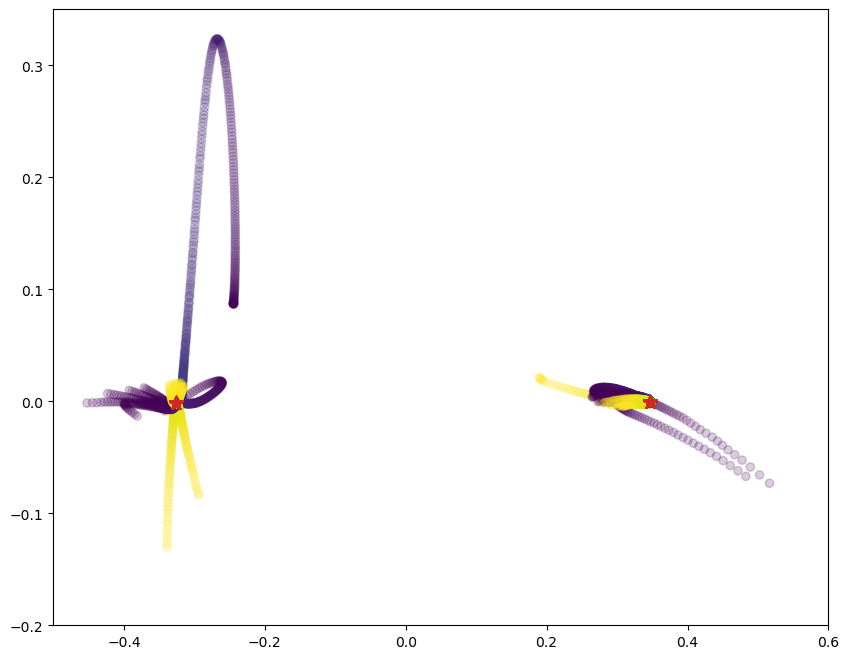

In [79]:
f, ax = plt.subplots(1, 1, figsize=(10, 8))
last_n_steps = 100
for i, split in enumerate(project_split[:-1]):
    ax.scatter(split[:, 0], split[:, 1], marker="o", c=colors[:split.shape[0]], cmap=cm.viridis, label="control", alpha=0.2)
    ax.scatter(proj_base_fp[:, 0], proj_base_fp[:, 1], marker="*", c="C3", s=100, label="baseline")
    ax.set_ylim([-0.2, 0.35])
    ax.set_xlim([-0.5, 0.6])
plt.show()

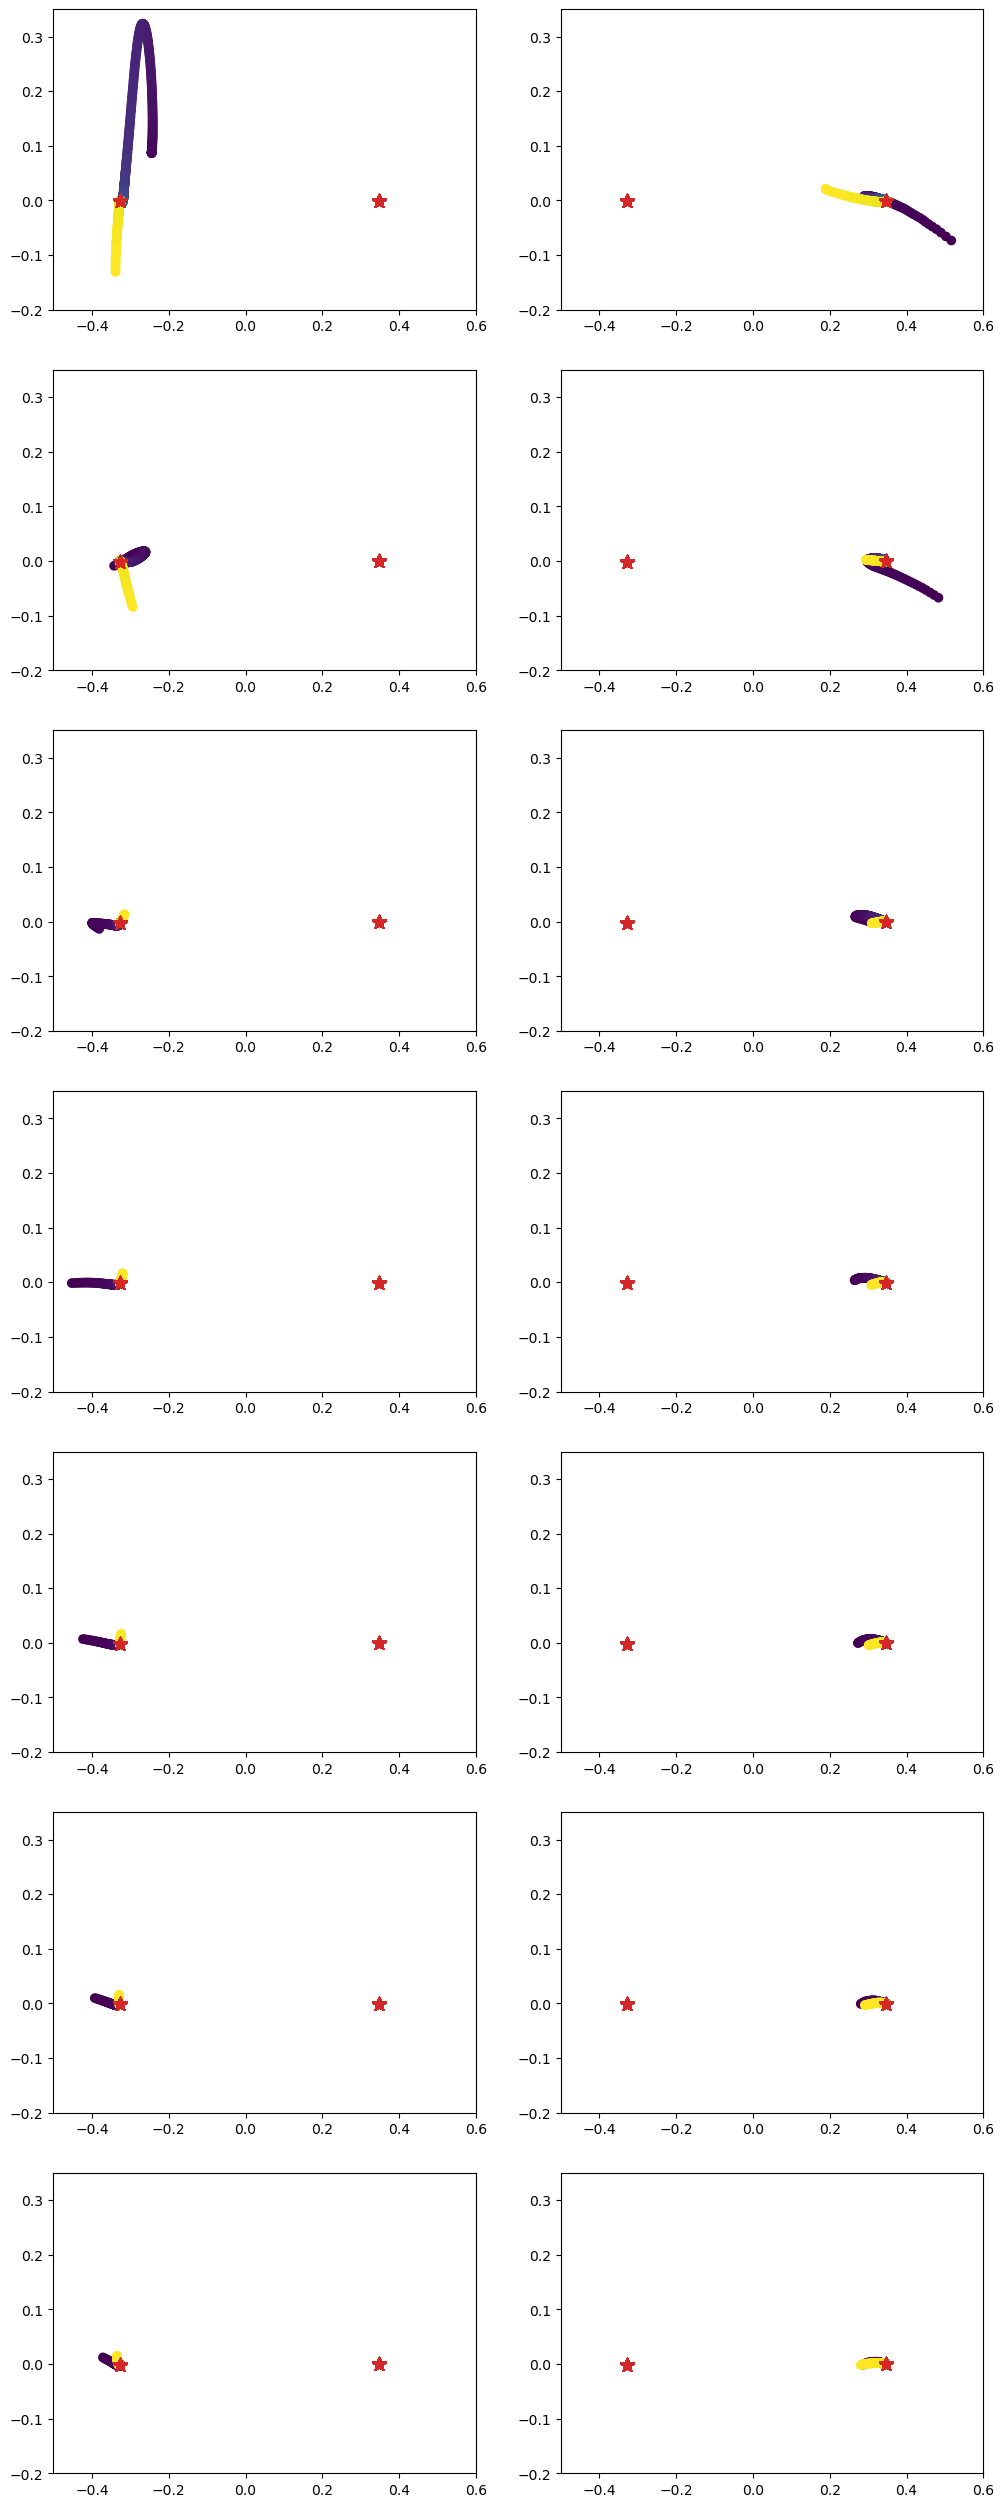

In [82]:
f, ax = plt.subplots(7, 2, figsize=(12, 32))
ax = ax.flatten()
for i, split in enumerate(project_split[:-1]):
    ax[i].scatter(split[:, 0], split[:, 1], marker="o", c=colors[:split.shape[0]], cmap=cm.viridis, label="control")
    ax[i].scatter(proj_base_fp[:, 0], proj_base_fp[:, 1], marker="*", c="C3", label="baseline", s=100)
    ax[i].set_ylim([-0.2, 0.35])
    ax[i].set_xlim([-0.5, 0.6])
plt.show()

# Thinkgs about Q

In [4]:
qa.results.params["equation_params"]["reg_coef"]

0.0

In [5]:
baseline_Q1, baseline_Q2, task_id_t =  qa.baseline_Q1, qa.baseline_Q2, qa.task_id_t.astype(bool)
control_Q1, control_Q2 = qa.control_Q1, qa.control_Q2
#tilde_Q1, tilde_Q2 = qa.tilde_Q1, qa.tilde_Q2
iters = qa.iters

In [6]:
baseline_Q2 @ baseline_Q1

array([[[-9.49832123e-05, -5.50844169e-04,  0.00000000e+00],
        [-3.59404842e-04,  6.75135188e-04,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[-8.01740470e-05, -5.08828441e-04,  0.00000000e+00],
        [-3.46064076e-04,  7.29878612e-04,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[-6.56169785e-05, -4.67074674e-04,  0.00000000e+00],
        [-3.32845225e-04,  7.84556514e-04,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       ...,

       [[ 8.36049778e-01,  2.40371935e-01,  0.00000000e+00],
        [ 5.60141859e-01,  2.07446263e-01,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 8.35884542e-01,  2.40513550e-01,  0.00000000e+00],
        [ 5.59990399e-01,  2.07819437e-01,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 8.35720485e-01,  2.40653783e-01,  0.00000000e+00],
 

In [7]:
def orthogonality_metric(Q1_t, Q2_t):
    metric = []
    for t_index in range(Q1_t.shape[0]):
        q = Q2_t[t_index, ...] @ Q1_t[t_index, ...]
        I = np.identity(q.shape[0])
        I[-1, :] = 0
        metric.append((np.mean( (I - q)**2 )))
    return np.array(metric)

In [8]:
baseline_metric = orthogonality_metric(baseline_Q1, baseline_Q2)
control_metric = orthogonality_metric(control_Q1, control_Q2)

baseline_metric1 = np.copy(baseline_metric)
baseline_metric1[task_id_t] = None
control_metric1 = np.copy(control_metric)
control_metric1[task_id_t] = None

baseline_metric2 = np.copy(baseline_metric)
baseline_metric2[np.logical_not(task_id_t)] = None
control_metric2 = np.copy(control_metric)
control_metric2[np.logical_not(task_id_t)] = None

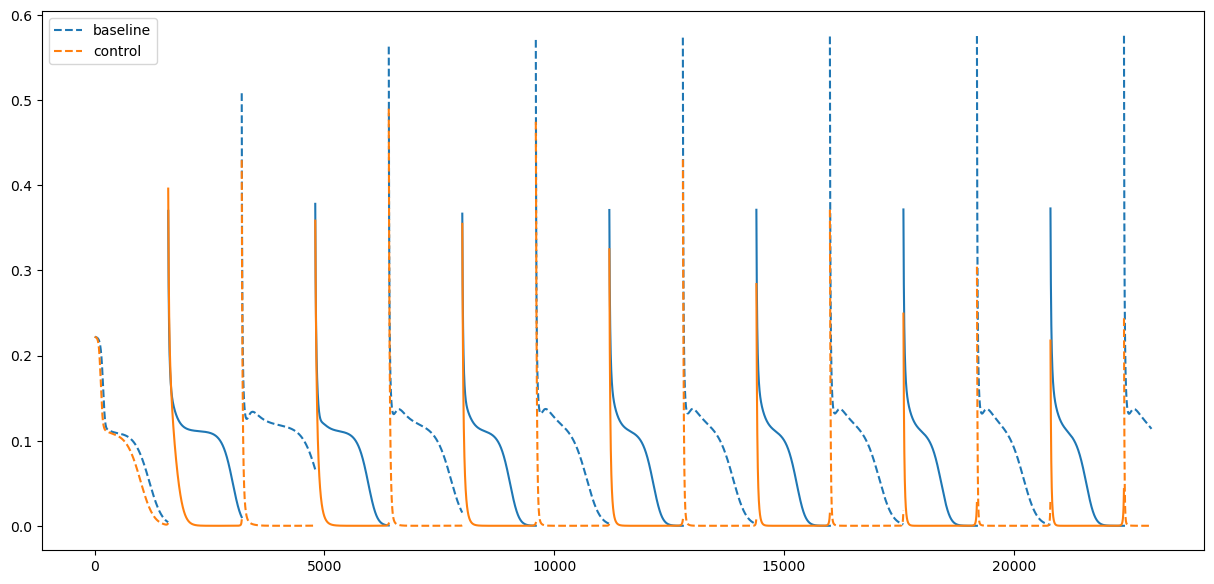

In [9]:
f, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.plot(iters, baseline_metric1, "C0--", label="baseline")
ax.plot(iters, control_metric1, "C1--", label="control")
ax.plot(iters, baseline_metric2, "C0")
ax.plot(iters, control_metric2, "C1")
ax.legend()
plt.show()

In [10]:
all_Q1 = np.concatenate([baseline_Q1, control_Q1], axis=0)
all_Q1 = np.reshape(all_Q1, (all_Q1.shape[0], -1))

all_Q2 = np.concatenate([baseline_Q2, control_Q2], axis=0)
all_Q2 = np.reshape(all_Q2, (all_Q2.shape[0], -1))

In [11]:
pca1 = PCA(n_components=2).fit(all_Q1)
pca2 = PCA(n_components=2).fit(all_Q2)

In [12]:
baseline_Q1_proj = pca1.transform(np.reshape(baseline_Q1, (baseline_Q1.shape[0], -1)))
control_Q1_proj = pca1.transform(np.reshape(control_Q1, (control_Q1.shape[0], -1)))

In [13]:
baseline_Q2_proj = pca2.transform(np.reshape(baseline_Q2, (baseline_Q2.shape[0], -1)))
control_Q2_proj = pca2.transform(np.reshape(control_Q2, (control_Q2.shape[0], -1)))

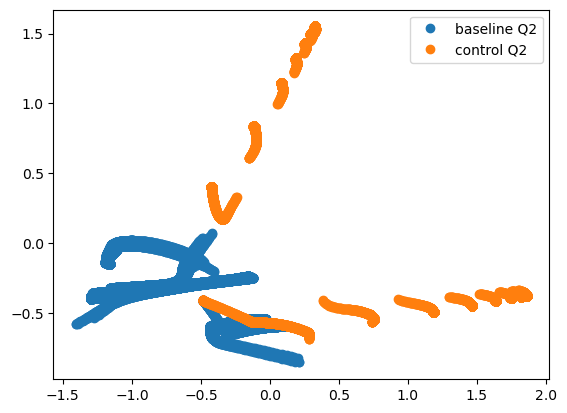

In [14]:
plt.plot(baseline_Q2_proj[:, 0], baseline_Q2_proj[:, 1], "o", label="baseline Q2")
plt.plot(control_Q2_proj[:, 0], control_Q2_proj[:, 1], "o", label="control Q2")
plt.legend()
plt.show()

In [15]:
#n_qs = 20
#Q12, losses12 = qa.sample_optimal_qs(qa.svd_task1, qa.cov_matrix_task2, n_qs=n_qs)
#Q21, losses21 = qa.sample_optimal_qs(qa.svd_task2, qa.cov_matrix_task1, n_qs=n_qs)

In [16]:
#import pickle
#pickle.dump({"Q12": Q12, "Q21": Q21, "losses12": losses12, "losses21": losses21}, 
#           open("optimal_qs_row_zero.pkl", "wb"), 
#            protocol=pickle.HIGHEST_PROTOCOL)

In [17]:
import pandas as pd
qs = pd.read_pickle("optimal_qs_row_zero.pkl")
Q12 = qs["Q12"]
Q21 = qs["Q21"]

In [18]:
print(qs["losses12"], qs["losses21"])

[0.10183783 0.10110715 0.09981104 0.10564272 0.10739496 0.11112329
 0.09912043 0.0993781  0.09901864 0.10094589 0.10639942 0.11783818
 0.09913607 0.09988125 0.10093364 0.10338354 0.15657591 0.09930752
 0.10136535 0.11210696] [0.13845602 0.15181552 0.13780981 0.13821089 0.13729149 0.13738381
 0.14639299 0.13773079 0.13883512 0.14219491 0.14506529 0.14526376
 0.13878653 0.14228281 0.13843756 0.13951821 0.13965839 0.1373399
 0.15552309 0.13855651]


In [19]:
Q12_inv = np.stack([np.linalg.pinv(Q12[i, ...]) for i in range(Q12.shape[0])], axis=0)
Q21_inv = np.stack([np.linalg.pinv(Q21[i, ...]) for i in range(Q21.shape[0])], axis=0)

In [20]:
Q12_projected = pca2.transform(np.reshape(Q12_inv, (Q12_inv.shape[0], -1)))
Q21_projected = pca2.transform(np.reshape(Q21_inv, (Q21_inv.shape[0], -1)))

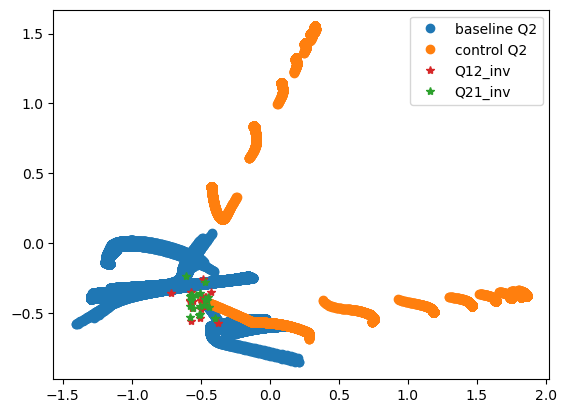

In [21]:
plt.plot(baseline_Q2_proj[:, 0], baseline_Q2_proj[:, 1], "o", label="baseline Q2")
plt.plot(control_Q2_proj[:, 0], control_Q2_proj[:, 1], "o", label="control Q2")
plt.plot(Q12_projected[:, 0], Q12_projected[:, 1], "C3*", label="Q12_inv")
plt.plot(Q21_projected[:, 0], Q21_projected[:, 1], "C2*", label="Q21_inv")
plt.legend()
plt.show()

In [22]:
Q12_projected_ = pca1.transform(np.reshape(Q12, (Q12.shape[0], -1)))
Q21_projected_ = pca1.transform(np.reshape(Q21, (Q21.shape[0], -1)))

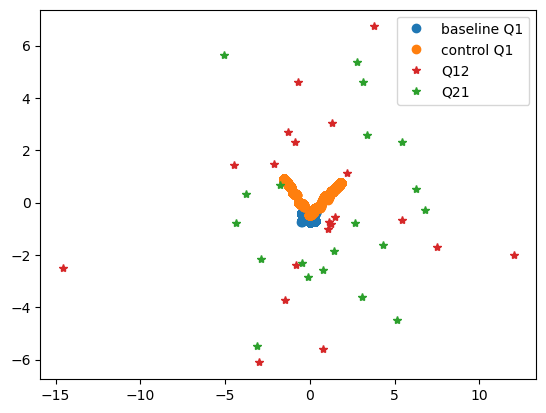

In [23]:
plt.plot(baseline_Q1_proj[:, 0], baseline_Q1_proj[:, 1], "o", label="baseline Q1")
plt.plot(control_Q1_proj[:, 0], control_Q1_proj[:, 1], "o", label="control Q1")
plt.plot(Q12_projected_[:, 0], Q12_projected_[:, 1], "C3*", label="Q12")
plt.plot(Q21_projected_[:, 0], Q21_projected_[:, 1], "C2*", label="Q21")
plt.legend()
plt.show()

In [24]:
Q12, baseline_Q1

(array([[[  3.4381754 ,  -9.998412  ,   0.        ],
         [  5.41524   , -11.259004  ,   0.        ],
         [ -0.9247641 ,   1.289999  ,   0.        ],
         [ -1.2742344 ,   7.89168   ,   0.        ],
         [  3.7382674 ,  -8.294202  ,   0.        ],
         [ -3.4895191 ,  -5.4656434 ,   0.        ]],
 
        [[ -3.1855993 ,   0.5420655 ,   0.        ],
         [ -0.5172528 ,  -2.1844573 ,   0.        ],
         [ -2.2328398 ,  -4.52773   ,   0.        ],
         [ -2.4920151 ,  -0.02069259,   0.        ],
         [ -0.3585778 ,  -0.56856894,   0.        ],
         [ -2.7207296 ,  -4.393225  ,   0.        ]],
 
        [[  2.878475  ,   0.6266784 ,   0.        ],
         [  7.682453  ,  -5.3549476 ,   0.        ],
         [  1.5816821 ,   3.6233904 ,   0.        ],
         [  0.87658   ,  -7.8468885 ,   0.        ],
         [ -1.3085656 ,   0.2758659 ,   0.        ],
         [ -3.399856  ,  -7.152874  ,   0.        ]],
 
        [[  2.615462  ,  -2.3204727 ,